# MultistageOT validated on lineage tracing data from mouse hematopoiesis.

In this notebook, we apply MultistageOT to the lineage tracing data in Weinreb et al. (2020). We benchmark the cell fate predictions against empirical clonal lineage-forming potential.

In [1]:
import numpy as np
import pandas as pd 
import sys
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sbn
import scipy 
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors 
sys.path.append("../../../../")

import packages.models.tools as tools

Define paths for loading and saving results:

In [2]:
################# Define paths: #################
DATA_PATH    = "../../../../data/real_data/weinreb2020/"
RESULTS_PATH = "../../../../results/real_data/weinreb2020/" 

filename_meta_data = "20231206_meta_data_with_clonal_information.csv"

# Load gene data

In [3]:
meta_data = pd.read_csv(DATA_PATH + filename_meta_data, index_col='Unnamed: 0')
embedding = meta_data[['SPRING-x','SPRING-y']]

embedding_norm = (embedding-embedding.min())/(embedding.max()-embedding.min()) 

The meta data contains annotations by Weinreb et al. (2020):

In [4]:
meta_data.head()

,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y,clone,num_clone_time_points
0,d6_2_2,GCGTGCAA-AGAAGTTA,6.0,Lin-Kit+Sca1-,Undifferentiated,2,411.496,-96.190,573.0,2.0
1,d6_2_2,AAGGGACC-CTCGATGC,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-587.462,-306.925,1440.0,2.0
2,d6_2_2,CGTACCGA-AGCGCCTT,6.0,Lin-Kit+Sca1-,Monocyte,2,1429.805,-429.300,394.0,2.0
3,d6_2_2,CTGAAGGG-AGGAGCTT,6.0,Lin-Kit+Sca1-,Neutrophil,2,1150.028,-2030.369,NaN,NaN
4,d6_2_2,CCGTAGCT-AGGCAGTT,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-1169.594,362.010,1972.0,2.0


# Load downstream data

The downstream results have been pre-computed:

In [5]:
datestamp = "20240305"

cell_fate_probabilities = pd.read_csv(DATA_PATH + "{datestamp}_cell_fate_probabilities.csv".format(datestamp=datestamp), index_col="Unnamed: 0")
marginals = pd.read_csv(DATA_PATH + "{datestamp}_marginals.csv".format(datestamp=datestamp), index_col="Unnamed: 0")
mass_to_terminals = pd.read_csv(DATA_PATH + "{datestamp}_mass_to_terminals.csv".format(datestamp=datestamp), index_col="Unnamed: 0")
pseudotime = pd.read_csv(DATA_PATH + "{datestamp}_pseudotime.csv".format(datestamp=datestamp), index_col="Unnamed: 0")

pseudotime.columns = ['pseudotime']
cell_fate_probabilities.index = cell_fate_probabilities.index.astype(int) 

Define some colors for each cell type:

In [6]:
cell_types = ['Monocyte',
            'Lymphoid',
            'Meg',
            'Neutrophil',
            'Eos',
            'Baso',
            'Mast',
            'Erythroid','pDC', 'Ccr7_DC']

cell_types_empirical = cell_types + ['Undifferentiated']

colors = np.array([[0,	111, 252], 
               [145, 254, 70],
               [30, 191, 193], 
               [208, 4, 38],
               [85, 50, 5],
               [254, 168, 64],
               [26, 136, 19],
               [251, 87, 252], [0,0,0], [255, 255,0]])

colors = colors/255


colors_empirical = np.array([[0,	111, 252], 
               [145, 254, 70],
               [30, 191, 193], 
               [208, 4, 38],
               [85, 50, 5],
               [254, 168, 64],
               [26, 136, 19],
               [251, 87, 252], [0,0,0], [255, 255,0],
               [225,225,225]])      

colors_empirical = colors_empirical/255

colors_dict = {cell_types[k] : colors[k] for k in range(len(cell_types))}


# Input data

Define an index of initial cells:

In [7]:
initial_cells = pseudotime[(pseudotime == 0).values].index #Initial cells correspond to pseudotime = 0
print(len(initial_cells), "initial cells")

120 initial cells


Define an index of terminal cells:

In [8]:
terminal_cells = mass_to_terminals.index

Create a dictionary mapping cell type annotation to terminal cells: 

In [9]:
fate_groups = { annotation : meta_data.loc[terminal_cells].loc[meta_data.loc[terminal_cells,'Cell type annotation'] == annotation].index for annotation in meta_data['Cell type annotation'].unique() if (annotation != 'Undifferentiated') }

We see a clear skew of initial cells towards the earliest time point, and terminal cells towards the latest time point:

In [10]:
meta_data.loc[initial_cells, 'Time point'].value_counts()

Time point
4.0    70
2.0    46
6.0     4
Name: count, dtype: int64

In [11]:
meta_data.loc[terminal_cells, 'Time point'].value_counts()

Time point
6.0    5716
4.0    1219
2.0      37
Name: count, dtype: int64

### Motivating the choice of root cells:

Below we plot the cells on the SPRING-plot colored by time point

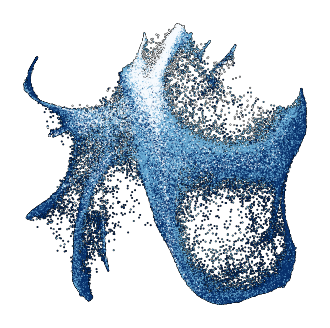

In [12]:
time = meta_data['Time point']
time = time.sample(frac=1)

fig, ax = plt.subplots(figsize=(4,4))

cmap = plt.get_cmap('Blues', 3)

plt.scatter(embedding['SPRING-x'],embedding['SPRING-y'], edgecolor='none', facecolor='k',s = 2)
plt.scatter(embedding.loc[time.index,'SPRING-x'],embedding.loc[time.index, 'SPRING-y'], 
            c=time, cmap=cmap,edgecolor='none',s = 0.75)

 
sbn.despine(bottom=True, left=True) 
plt.xticks([]) 
plt.yticks([]) 
plt.savefig(RESULTS_PATH + "figures/{datestamp}_actual_time_points.png".format(datestamp=datestamp),transparent=True, dpi=600, bbox_inches='tight')

This is a visualization of all the initial (black), intermediate (grey) and terminal (colored) cells used as input to our optimal transport model:

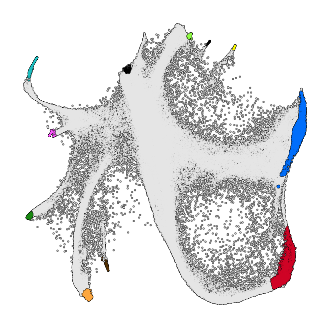

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(embedding['SPRING-x'],embedding['SPRING-y'], edgecolor='none', facecolor='k',s = 2)
plt.scatter(embedding['SPRING-x'],embedding['SPRING-y'], 
            facecolor=[0.9,0.9,0.9], edgecolor='none',s = 0.75)


plt.scatter(embedding.loc[initial_cells]['SPRING-x'],embedding.loc[initial_cells]['SPRING-y'],
            s = 1, edgecolor='none',facecolor='k')
 

[plt.scatter(embedding.loc[fate_groups[cell_types[k]]]['SPRING-x'],embedding.loc[fate_groups[cell_types[k]]]['SPRING-y'],
            s = 2.25, edgecolor='none', facecolor='k') for k in range(len(cell_types))]
[plt.scatter(embedding.loc[fate_groups[cell_types[k]]]['SPRING-x'],embedding.loc[fate_groups[cell_types[k]]]['SPRING-y'],
            s = 1, edgecolor='none', facecolor=colors[k]) for k in range(len(cell_types))]


#plt.title('Pseudotemporal ordering')
sbn.despine(bottom=True, left=True) 
plt.xticks([]) 
plt.yticks([]) 

# Visualize results

## MultistageOT cell fate probabilities

By aggregating the optimal mass transports over all time points, and normalizing by total mass for each cell, we obtain transition probabilities for each cell (see Methods section in manuscript). These were used to estimate the cell fate probabilities (Methods), quantifying the probability of a cell ending up in each of the 10 different mature cell fates. We visualize these fate probabilities with a pie chart for each cell (it takes a while to plot all cells, so one might want plot a subset of the cells, using the `frac` argument, controlling the fraction of cells that is plotted):

 Plotting cell nr 130884/130884

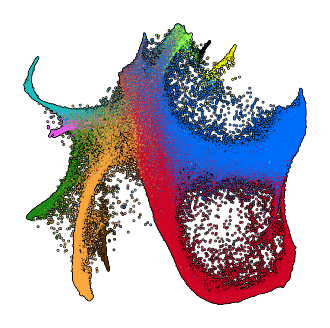

In [93]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4)) 
tools.plot_fate_probabilities_with_pie_charts(ax,embedding.loc[cell_fate_probabilities.index],
                                cell_fate_probabilities,
                                entropy_fade=False, frac=1, plot_order=cell_types, colors=colors, s=1, background=0.3)

# Show the plot
sbn.despine(left=True, bottom=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + "figures/{datestamp}_cell_fate_probabilities_transparent.png".format(datestamp=datestamp), dpi=600, transparent=True,bbox_inches='tight')

### Original author annotations

The original authors (Weinreb et al., 2020) had annotated the data  set. We visualize this annotation now. Each color represents a different cell type:

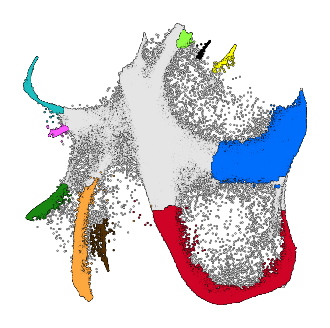

In [14]:
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(embedding['SPRING-x'],embedding['SPRING-y'], edgecolor='none', facecolor='k',s = 2)
plt.scatter(embedding['SPRING-x'],embedding['SPRING-y'], 
            facecolor=[0.9,0.9,0.9], edgecolor='none',s = 0.75)

[plt.scatter(embedding.loc[embedding.loc[meta_data['Cell type annotation'] == cell_types[k]].index,'SPRING-x'],embedding.loc[embedding.loc[meta_data['Cell type annotation'] == cell_types[k]].index,'SPRING-y'],
            s = 2.25, edgecolor='none', facecolor='k') for k in range(len(cell_types))]
[plt.scatter(embedding.loc[embedding.loc[meta_data['Cell type annotation'] == cell_types[k]].index,'SPRING-x'],embedding.loc[embedding.loc[meta_data['Cell type annotation'] == cell_types[k]].index,'SPRING-y'],
            s = 1, edgecolor='none', facecolor=colors[k]) for k in range(len(cell_types))]

sbn.despine(bottom=True, left=True) 
plt.xticks([]) 
plt.yticks([]) 

## Pseudotime

Another downstream analysis afforded by the MultistageOT model is to order cells along a pseudotemporal axis. We visualize this now.

Plot the pseudotime value for each cell on the SPRING-embedding:

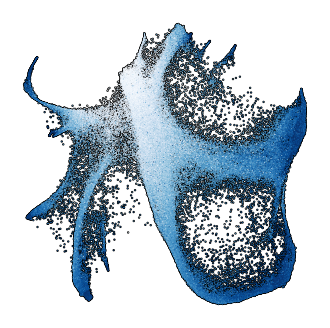

In [15]:
fig, ax = plt.subplots(figsize=(4,4))


plt.scatter(embedding.loc[pseudotime.index]['SPRING-x'],embedding.loc[pseudotime.index]['SPRING-y'],
            s = 0.5, edgecolor='k',facecolor='none')  
plt.scatter(embedding.loc[pseudotime.index]['SPRING-x'],embedding.loc[pseudotime.index]['SPRING-y'], 
            c=pseudotime.values, edgecolor='none',cmap='Blues', s = 0.5)

#plt.title('Pseudotemporal ordering')
sbn.despine(bottom=True, left=True) 
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + "figures/{datestamp}_pseudotime.png".format(datestamp=datestamp), dpi=600, bbox_inches='tight')


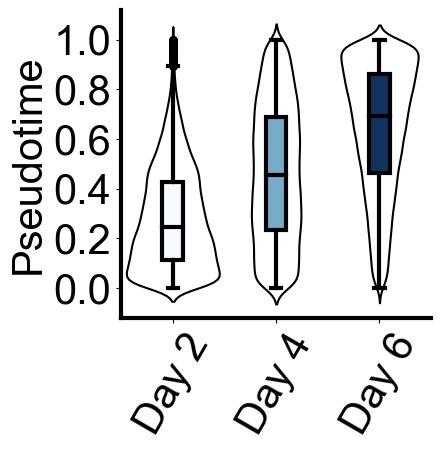

In [16]:
pseudotime_real_time_df = pseudotime.copy()
pseudotime_real_time_df['Day'] = time.loc[pseudotime.index]
cmap = plt.get_cmap('Blues', 3)


fig, ax = plt.subplots(figsize=(4,4))
sbn.violinplot(ax=ax,data=pseudotime_real_time_df, width=0.9, linewidth=1.5,edgecolor='k', x="Day", y="pseudotime", inner=None, color='w');
sbn.despine()

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3);
ax.set_yticks([0.2*k for k in range(6)], [str(np.round(0.2*k,1)) for k in range(6)],fontsize=30, **{'fontname':'Arial'})

flierprops = dict(marker='o', markerfacecolor='None', markersize=5,  markeredgecolor='black')
sbn.boxplot(ax=ax,data=pseudotime_real_time_df,width=0.2, x="Day", y="pseudotime",palette={2.0*k : cmap((k-1)/2) for k in range(1,4)}, labels=None,flierprops=flierprops,zorder=10)
for box in ax.patches:
    box.set_edgecolor('k')
    box.set_zorder(100)
    box.set_alpha(1)
    box.set_linewidth(3)

[ax.collections[k].set_edgecolor('k') for k in range(len(ax.collections))]
plt.setp(ax.artists, alpha=1,edgecolor = 'k', linewidth=3,facecolor='w')
plt.setp(ax.lines,alpha=1,color='k', linewidth=3,zorder=100) 

ax.set_xticklabels(['Day 2','Day 4','Day 6'], rotation=60,fontsize=30,**{'fontname':'Arial'})
ax.set_ylabel('Pseudotime', fontsize=30,**{'fontname':'Arial'})
ax.set(xlabel=None)

Test for equal variance:

In [17]:
var_p = [scipy.stats.levene(pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 2.0,'pseudotime'], pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 4.0,'pseudotime']), 
        scipy.stats.levene(pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 4.0,'pseudotime'], pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 6.0,'pseudotime']),
        scipy.stats.levene(pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 2.0,'pseudotime'], pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 6.0,'pseudotime'])]
var_p

[LeveneResult(statistic=4471.775065066285, pvalue=0.0),
 LeveneResult(statistic=470.9185190800137, pvalue=3.4735294114095536e-104),
 LeveneResult(statistic=1961.1664780840122, pvalue=0.0)]

Variances are not equal.

Test for normality:

In [18]:
normal_test = [scipy.stats.normaltest(pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 2.0,'pseudotime']), 
        scipy.stats.normaltest(pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 4.0,'pseudotime']),
        scipy.stats.normaltest(pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 2.0,'pseudotime'])]
normal_test

[NormaltestResult(statistic=1889.6548653189138, pvalue=0.0),
 NormaltestResult(statistic=18448.780113844874, pvalue=0.0),
 NormaltestResult(statistic=1889.6548653189138, pvalue=0.0)]

The pseudotime groups are not normal distributed, so we perform the Mann-Whitney U-test instead:

In [19]:
p = [scipy.stats.mannwhitneyu(pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 2.0,'pseudotime'], pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 4.0,'pseudotime']), 
        scipy.stats.mannwhitneyu(pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 4.0,'pseudotime'], pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 6.0,'pseudotime']),
        scipy.stats.mannwhitneyu(pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 2.0,'pseudotime'], pseudotime_real_time_df.loc[pseudotime_real_time_df['Day'] == 6.0,'pseudotime'])]
p

[MannwhitneyuResult(statistic=420015814.0, pvalue=0.0),
 MannwhitneyuResult(statistic=831277582.5, pvalue=0.0),
 MannwhitneyuResult(statistic=230912791.5, pvalue=0.0)]

Create a colorbar:

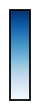

In [20]:
import matplotlib as mpl
fig = plt.figure(figsize=(8, 1))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_genes = mpl.colorbar.ColorbarBase(ax, cmap='Blues', 
                                orientation='vertical')
cb_genes.set_ticks([])
cb_genes.outline.set_linewidth(1.25)

## Benchmarking cell-fate predictive performance

We begin by comparing the dominant fate predictions with the author's own annotations

In [21]:
cell_fate_probabilities.idxmax(axis=1)

87878           Baso
87187     Neutrophil
58471     Neutrophil
104120    Neutrophil
91423     Neutrophil
             ...    
114868      Monocyte
25435       Monocyte
112678      Monocyte
9991        Monocyte
40501       Monocyte
Length: 130884, dtype: object

In [22]:
meta_data_sub = meta_data.loc[cell_fate_probabilities.index]

#We do not consider undifferentiated cells:
meta_data_sub = meta_data_sub.loc[meta_data_sub['Cell type annotation'] != 'Undifferentiated']
annotations = meta_data_sub['Cell type annotation']

#We do not consider cells included in our list of terminal cells 
#(as these were used in "training" the MultistageOT model):
excluded_terminals = np.array([idx for idx in annotations.index if idx not in terminal_cells])
num_annotations = len(excluded_terminals)

In [23]:
annotations.loc[excluded_terminals]

22667       Monocyte
28632     Neutrophil
110445      Monocyte
77791       Monocyte
77156       Monocyte
             ...    
119815      Monocyte
37831           Baso
28790            Meg
73026           Baso
4820        Monocyte
Name: Cell type annotation, Length: 51720, dtype: object

We check how many matches there are in the dominant (highest fate probability) predicted fate:

In [24]:
(annotations.loc[excluded_terminals] == cell_fate_probabilities.loc[excluded_terminals].idxmax(axis=1)).sum() / num_annotations

0.9814191802010828

To benchmark the performance of our model's cell fate predictions, we compare our model's estimated cell fate probabilities of day two cells (earliest time point) to the observed distribution of their clonal sisters in each fate at days 4 and 6.

### Selecting day two cells:

We first select the day two cells. Note that we only look at day two cells that have a clone associated with cells in more than 1 time point. In addition, we make sure that the day two cells are not within our identified "terminal cells", as this would otherwise give a favorable bias to our model predictions. Finally, we also ensure no clone exists in more 1 experiment (there are three: two as LK cells ("d" or LK_"), and one as LSK cells ("LSK_"))

In [25]:
libraries = sorted(meta_data['Library'].unique())

for library in libraries:
    print(library)

LK_d2
LK_d4_1
LK_d4_2
LK_d6_1_1
LK_d6_1_2
LK_d6_2_1
LK_d6_2_2
LSK_d2_1
LSK_d2_2
LSK_d2_3
LSK_d4_1_1
LSK_d4_1_2
LSK_d4_1_3
LSK_d4_2_1
LSK_d4_2_2
LSK_d4_2_3
LSK_d6_1_1
LSK_d6_1_2
LSK_d6_1_3
LSK_d6_2_1
LSK_d6_2_2
LSK_d6_2_3
d2_1
d2_2
d2_3
d4_1_1
d4_1_2
d4_2_1
d4_2_2
d4_2_4
d6_1_1
d6_1_2
d6_2_1
d6_2_2
d6_2_3


In [26]:
defective_clone_list = []
for clone in meta_data['clone'].unique():
    
    #Get the different libraries represented by this clone:
    libraries = meta_data.loc[meta_data['clone'] == clone, 'Library'].unique()

    #Extract identifiers "d", "LK" or "LSK":
    library_types = np.unique([library[0] if (library[0] == 'd') else library[:2] if (library[:2] == 'LK') else library[:3] for library in libraries])
    
    #If the clone has cells represented in more than one library "type" (d, LK or LSK)
    #we consider it duplicated over different experiments, and therefore we do not trust it.
    if len(library_types) > 1:
        defective_clone_list.append(clone)

In [27]:
#First filter:
day_two_cells = meta_data.loc[(meta_data['Time point'] == 2.0) & 
                             (~meta_data['clone'].isna()) & 
                              (meta_data['num_clone_time_points'] > 1.0) & 
                              ~meta_data['clone'].isin(defective_clone_list)].index

#We excluded 3 cells when running our model, so we ensure to only keep cells that have corresponding
#cell fate predictions:
day_two_cells = [cell for cell in day_two_cells if cell in cell_fate_probabilities.index]

#Ensure none of the selected day two cell is part of the set of terminal cell states:
day_two_cells = [cell for cell in day_two_cells if cell not in terminal_cells]

### Empirical clonal sister fate distribution

We only consider clones that are unique over the two starting populations. I.e., if the same clone appears in both, we exclude it:

Compute an empirical distribution of cell fates for each day two cell:

In [28]:
fates_df = pd.DataFrame(np.zeros((len(day_two_cells),len(meta_data['Cell type annotation'].unique()))), index=day_two_cells, columns=meta_data['Cell type annotation'].unique())

for cell in day_two_cells:
    #Find corresponding clone of this day two cell:
    clone = meta_data.loc[cell, 'clone']
    
    #If the cell is annotated as a particular cell type,
    if meta_data.loc[cell,'Cell type annotation'] != 'Undifferentiated': 
        #then we assume it is 100% committed to that lineage:
        fates_df.loc[cell, meta_data.loc[cell,'Cell type annotation']] = 1.0

    #Otherwise: 
    else:           
        #Count the number of clonal sisters in each fate in later time points:
        sisters_fates_counts = meta_data.loc[(meta_data['clone'] == clone) & (meta_data['Time point'] > 2.0),'Cell type annotation'].value_counts()
                                                     
        #Estimate its cell fate probabilities based on the distribution of clonal sisters:
        sisters_fates_probabilities =  sisters_fates_counts / sisters_fates_counts.sum()

        #Non-zero empirical fate probabilities:
        sisters_fates = sisters_fates_counts.index 
        
        #Update DataFrame:
        fates_df.loc[cell, sisters_fates] =  sisters_fates_probabilities.values

The proportion of clonal sister in each fate is represented in the `fates_df` dataframe:

In [29]:
fates_df.tail(10).round(3)

,Undifferentiated,Monocyte,Neutrophil,Baso,Mast,Erythroid,Meg,Ccr7_DC,Lymphoid,Eos,pDC
69296,0.000,1.000,0.000,0.00,0.0,0.0,0.000,0.000,0.0,0.00,0.0
69297,0.667,0.000,0.000,0.00,0.0,0.0,0.000,0.333,0.0,0.00,0.0
69299,0.080,0.000,0.000,0.88,0.0,0.0,0.000,0.000,0.0,0.04,0.0
69301,0.000,1.000,0.000,0.00,0.0,0.0,0.000,0.000,0.0,0.00,0.0
69308,0.167,0.000,0.833,0.00,0.0,0.0,0.000,0.000,0.0,0.00,0.0
69312,0.000,0.000,1.000,0.00,0.0,0.0,0.000,0.000,0.0,0.00,0.0
69313,0.000,0.000,0.000,0.00,0.0,0.0,1.000,0.000,0.0,0.00,0.0
69317,0.333,0.333,0.333,0.00,0.0,0.0,0.000,0.000,0.0,0.00,0.0
69322,0.667,0.000,0.000,0.00,0.0,0.0,0.333,0.000,0.0,0.00,0.0
69326,0.250,0.250,0.500,0.00,0.0,0.0,0.000,0.000,0.0,0.00,0.0


### Example: visualization of empirical fate distribution

 Below we visualize the fate distribution of day four or six clonal sisters of a representative day two cell. We select the cell with the largest clone: 

In [30]:
#Identify clone with largest number of clonal sisters in all three time points:
top_clone = meta_data.loc[meta_data['num_clone_time_points'] == 3.0]['clone'].value_counts().index[0]
top_clone_cells = meta_data.loc[meta_data['clone'] == top_clone].index

#Single out the (in this case only) day two cell in this clone:
day_2_clone_cell_example_df = meta_data.loc[(meta_data['clone'] == top_clone) & (meta_data['Time point'] == 2.0)]
print("Example cell:")
day_2_clone_cell_example_df

Example cell:


,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y,clone,num_clone_time_points
68688,LK_d2,GCTATGGG-GGGAGGTA,2.0,Lin-Kit+Sca1-,Undifferentiated,0,313.262,262.742,1261.0,3.0


We see that it indeed has clonal sisters of different cell types in day 4 as well as day 6:

In [31]:
meta_data.loc[meta_data['clone'] == top_clone][['Cell type annotation', 'Time point']].value_counts()

Cell type annotation  Time point
Neutrophil            6.0           105
Monocyte              6.0            30
Undifferentiated      6.0            21
                      4.0            11
Neutrophil            4.0             8
Baso                  6.0             1
Undifferentiated      2.0             1
Name: count, dtype: int64

Visualize the distribution of clonal sisters in each cell fate with a pie chart:

All possible fates:

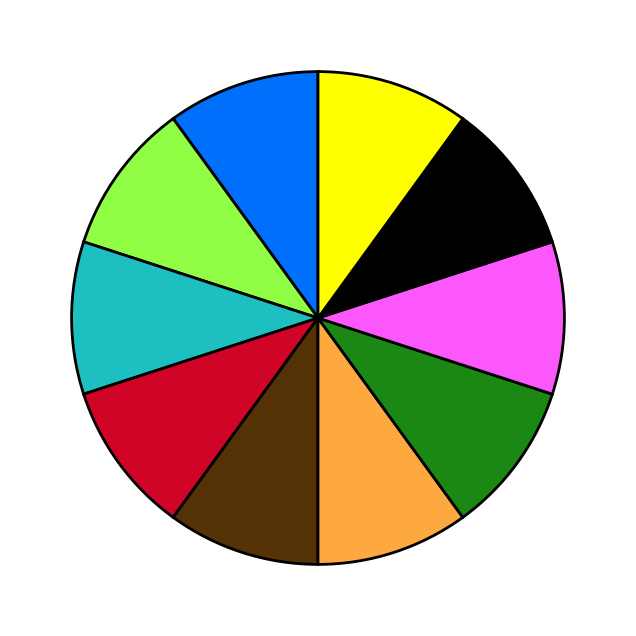

In [32]:
# Plot the pie chart
plt.figure(figsize=(8, 8))

values = np.array([1/cell_fate_probabilities.shape[1] for k in range(cell_fate_probabilities.shape[1])]) 

#test_values = [0.1, 0.2, 0.3, 0.4]
#test_colors = plt.get_cmap('Set3')([k for k in range(cell_fate_probabilities.shape[1])])

plt.pie(values, colors=colors,  
        startangle=90, 
        wedgeprops={ 'linewidth' : 2, 'edgecolor' : 'k',  'antialiased': True});

Fate distribution for the example clone:

Day two cell:  68688
Clone nr: 1261

Fate distribution of its clonal sisters:
Cell type annotation
Neutrophil          113
Undifferentiated     32
Monocyte             30
Baso                  1
Name: count, dtype: int64
(0 clonal sisters in other fates).
Cell type annotation  Neutrophil  Undifferentiated  Monocyte      Baso
count                   0.642045          0.181818  0.170455  0.005682
 Plotting cell nr 1/130887

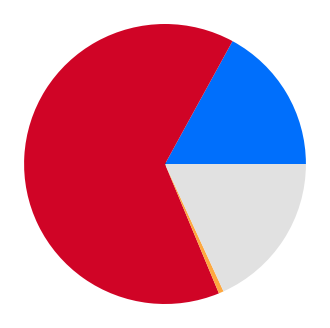

In [33]:
day_2_clone_cell_example = day_2_clone_cell_example_df.index[0]

sisters_fates_counts = meta_data.loc[(meta_data['clone'] == top_clone) & 
                                     (meta_data['Time point'] > 2.0),
                                     'Cell type annotation'].value_counts()

print("Day two cell: ",day_2_clone_cell_example)
print("Clone nr:", int(top_clone))
print("\nFate distribution of its clonal sisters:")
print(sisters_fates_counts)
print("(0 clonal sisters in other fates).")

#Estimate its cell fate probabilities via the distribution of clonal sisters:
sisters_fates_probabilities =  sisters_fates_counts / sisters_fates_counts.sum()
 
print(pd.DataFrame(sisters_fates_probabilities).T)

fig, ax = plt.subplots(figsize=(4,4))
tools.plot_fate_probabilities_with_pie_charts(ax,embedding,
                                fates_df,
                                entropy_fade=False, frac=1, plot_order=cell_types_empirical, indices=[day_2_clone_cell_example],colors=colors_empirical, s=100, background=1)
sbn.despine(bottom=True, left=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])

Below, we visualize the same day two cell, together with its clonal sisters, on the SPRING-plot embedding:

 Plotting cell nr 1/130887

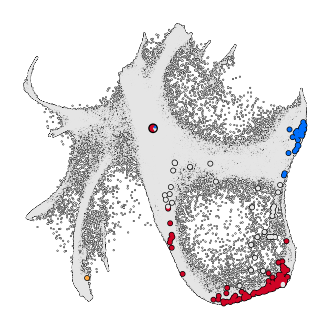

In [34]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], edgecolor='none', facecolor='k',s = 2)
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], 
            facecolor=[0.9,0.9,0.9], edgecolor='none',s = 0.75)

ax.scatter(embedding_norm.loc[top_clone_cells,'SPRING-x'],embedding_norm.loc[top_clone_cells,'SPRING-y'], edgecolor='k', facecolor='none',s = 10)
for cell in top_clone_cells: #Plot clonal sisters

    cell_type = meta_data.loc[cell,'Cell type annotation'] #Extract cell type

    if cell == day_2_clone_cell_example: #If the clonal sister is the day two cell itself, plot its pie chart:
        tools.plot_fate_probabilities_with_pie_charts(ax,embedding_norm,
                    fates_df,
                    entropy_fade=False, frac=1, plot_order=cell_types_empirical, 
                    indices=[cell],colors=colors_empirical, s=30, background=30)
                    
    else: #Otherwise, plot the clonal sister with a color corresponding to its cell type:
        if cell_type == 'Undifferentiated':
            ax.scatter(embedding_norm.loc[cell,'SPRING-x'],embedding_norm.loc[cell,'SPRING-y'], edgecolor='none', facecolor=[0.9,0.9,0.9],s = 10)
        else:
            ax.scatter(embedding_norm.loc[cell,'SPRING-x'],embedding_norm.loc[cell,'SPRING-y'], facecolor=colors_dict[cell_type], edgecolor='none',s = 10)

sbn.despine(bottom=True, left=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([]) 

We perform some additional filtering on the day two cells. We keep only clones of sufficient size in day 4 and 6 to give reasonable statistics (somewhat arbitrary but we choose 7). We also exclude day two cells with *only* "Undifferentiated" clonal sisters in the later time points.

In [35]:
day_two_cells_to_keep = []
clone_size_dict = {}
clone_sizes = []
meta_data

clone_size_threshold = 7

for cell in day_two_cells:
    #Find the size of the clone in days 4 and 6:
    clone_size = meta_data.loc[(meta_data['clone'] == meta_data.loc[cell,'clone']) & 
                               (meta_data['Time point'] > 2.0) ].shape[0]
    clone_size_dict[cell] = clone_size
    clone_sizes.append(clone_size)

    #If the cell's clone is sufficiently large, and its distribution of clonal sisters is not all 'Undifferentiated'
    #we keep the cell for benchmarking:
    if (clone_size >= clone_size_threshold) and fates_df.loc[cell, 'Undifferentiated'] != 1.0:
        day_two_cells_to_keep.append(cell)

We ignore the "Undifferentiated" fate for the remaining day two cells (and normalize the other fate-fractions so that they sum to unity):

In [36]:
fates_df_without_undiff = fates_df.loc[day_two_cells_to_keep].iloc[:,1:]
fates_df_without_undiff = fates_df_without_undiff.div(fates_df_without_undiff.sum(axis=1),axis=0)

Sanity check: we ensure none of the day two cells are in the set of terminal cell states (which we have assumed to be a priori known).

In [37]:
[idx for idx in fates_df_without_undiff.index if idx in terminal_cells]

[]

We end up with 795 cells on which we can benchmark our predicted fate probabilities:

In [38]:
fates_df_without_undiff.shape

(795, 10)

This is how the example cell's fate proabilities now look:

 Plotting cell nr 1/130887Monocyte      0.208333
Neutrophil    0.784722
Baso          0.006944
Mast          0.000000
Erythroid     0.000000
Meg           0.000000
Ccr7_DC       0.000000
Lymphoid      0.000000
Eos           0.000000
pDC           0.000000
Name: 68688, dtype: float64


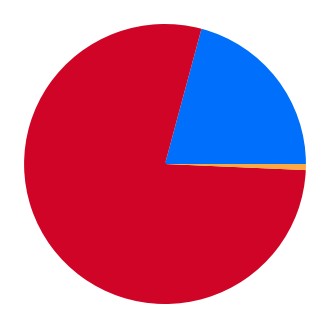

In [39]:

fig,ax = plt.subplots(figsize=(4,4))

tools.plot_fate_probabilities_with_pie_charts(ax,embedding,
                               fates_df_without_undiff,
                               entropy_fade=False, frac=1, plot_order=cell_types, indices=[day_2_clone_cell_example],colors=colors, s=100, background=1)
# Show the plot
sbn.despine(left=True,bottom=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])
plt.style.use("default")
print(fates_df_without_undiff.loc[day_2_clone_cell_example])

Plot the observed clonal fate distribution for each day two cell, as well as our model's cell fate predictions. We represent both distributions with pie charts. We will track the empirical fate probabilities with `q`:

In [ ]:
q = fates_df_without_undiff.copy()

Compare MultistageOT predictions to empirical distributions of the fates of clonal sisters:

 Plotting cell nr 795/130887

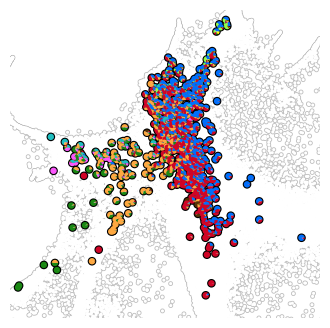

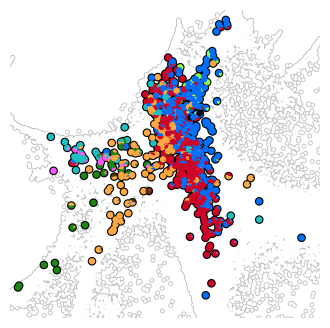

In [40]:
fig,ax = plt.subplots(figsize=(4,4))

# Create the scatter plot 
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor=[0.75,0.75,0.75],edgecolor='none', s=12)
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor='w',edgecolor='none', s=5)

# Create the scatter plot
np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding,
                               cell_fate_probabilities,
                               entropy_fade=False, frac=1, plot_order=cell_types, indices=day_two_cells_to_keep,colors=colors, s=10, background=22)
# Show the plot
sbn.despine(left=True,bottom=True)
ax.get_legend().remove()
plt.ylim([0.28,0.99])
plt.xlim([0.04,0.75])
plt.xticks([])
plt.yticks([])
plt.style.use("default")

fig,ax = plt.subplots(figsize=(4,4))

# Create the scatter plot 
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor=[0.75,0.75,0.75],edgecolor='none', s=12)
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor='w',edgecolor='none', s=5)

np.random.seed(123)
# Create the scatter plot
tools.plot_fate_probabilities_with_pie_charts(ax,embedding,
                               fates_df_without_undiff,
                               entropy_fade=False, frac=1, plot_order=cell_types, indices=day_two_cells_to_keep,colors=colors, s=10, background=22)
# Show the plot
sbn.despine(left=True,bottom=True)
ax.get_legend().remove()
plt.ylim([0.28,0.99])
plt.xlim([0.04,0.75])
plt.xticks([])
plt.yticks([])
plt.style.use("default")

A visual inspection suggest there is good correspondence between the observed clonal fates and our predictions. Next, we make this comparison rigorous:

###  Inverse Distance Weighted (IDW) predictor model

We compare our MultistageOT model predictions to predictions made using an Inverse Distance Weighted model. This represents a more naive predictor, only using relative Euclidean distances to the different fates, together with relative cell type frequencies, as the basis for cell fate inference.

We track the observed fate probabilities DataFrame using the variable `q`:

In [77]:
p_idw_all = pd.read_csv(DATA_PATH + "{datestamp}_idw_model_cell_fate_probabilities.csv".format(datestamp=datestamp), index_col="Unnamed: 0")
p_idw_all.index = p_idw_all.index.astype(int)

Compute relative distances to each fate (see Methods in manuscript):

 Plotting cell nr 795/130887

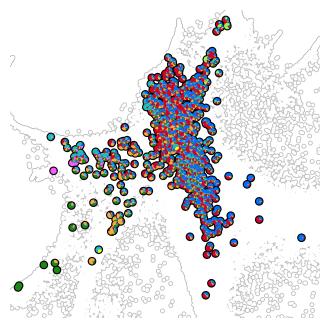

In [51]:
#Plot predictions for all day two cells:
fig,ax = plt.subplots(figsize=(4,4))

# Create the scatter plot 
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor=[0.75,0.75,0.75],edgecolor='none', s=12)
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor='w',edgecolor='none', s=5)

# Create the scatter plot
np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding_norm,
                               p_idw_all,
                               entropy_fade=False, frac=1, plot_order=cell_types, indices=day_two_cells_to_keep,colors=colors_empirical,  s=10, background=22)
# Show the plot
sbn.despine(left=True,bottom=True)
ax.get_legend().remove()
plt.ylim([0.28,0.99])
plt.xlim([0.04,0.75])
plt.xticks([])
plt.yticks([])

 Plotting cell nr 130887/130887

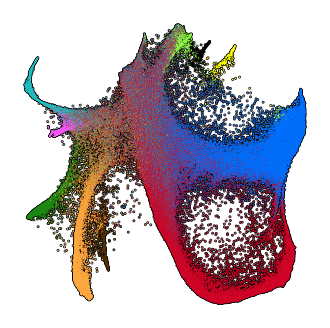

In [53]:
fig,ax = plt.subplots(figsize=(4,4))

embedding = meta_data[['SPRING-x','SPRING-y']]

# Create the scatter plot 
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor=[0.9,0.9,0.9],edgecolor='none', s=3)

# Create the scatter plot
np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding_norm,
                               p_idw_all,
                               entropy_fade=False, frac=1, plot_order=cell_types, colors=colors_empirical, s=1, background=0.3)

# Show the plot
sbn.despine(left=True,bottom=True)
ax.get_legend().remove()

plt.xticks([])
plt.yticks([])

Check against annotations:

In [56]:
(annotations.loc[excluded_terminals] == p_idw.loc[excluded_terminals].idxmax(axis=1)).sum() / num_annotations

0.978538283062645

### Load StationaryOT predictions:

In [57]:
cell_fate_probabilities_statot = pd.read_csv(DATA_PATH + '20240910_cell_fates_stationaryot.csv')
cell_fate_probabilities_statot.index = cell_fate_probabilities_statot["Unnamed: 0"].values
cell_fate_probabilities_statot = cell_fate_probabilities_statot.drop(columns="Unnamed: 0")
p_stationaryot = cell_fate_probabilities_statot.loc[q.index, q.columns]

 Plotting cell nr 130884/130884

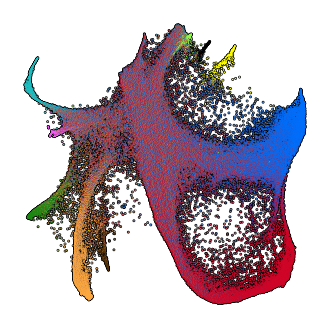

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))

embedding = meta_data[['SPRING-x','SPRING-y']]

# Create the scatter plot 
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor=[0.9,0.9,0.9],edgecolor='none', s=3)

# Create the scatter plot
np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding_norm.loc[cell_fate_probabilities_statot.index],
                               cell_fate_probabilities_statot,
                               entropy_fade=False, frac=1, plot_order=cell_types, colors=colors_empirical, s=1, background=0.3)

# Show the plot
sbn.despine(left=True,bottom=True)
ax.get_legend().remove()

plt.xticks([])
plt.yticks([])

 Plotting cell nr 795/130887

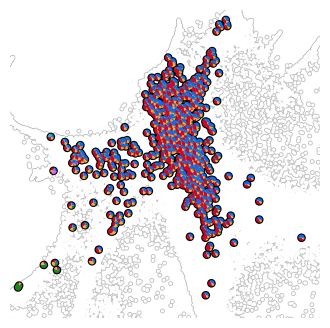

In [80]:
#Plot predictions for all day two cells:

fig,ax = plt.subplots(figsize=(4,4))

# Create the scatter plot 
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor=[0.75,0.75,0.75],edgecolor='none', s=12)
ax.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor='w',edgecolor='none', s=5)

# Create the scatter plot
np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding_norm,
                               p_stationaryot,
                               entropy_fade=False, frac=1, plot_order=cell_types, indices=p_stationaryot.index,colors=colors_empirical,  s=10, background=22)
# Show the plot
sbn.despine(left=True,bottom=True)
ax.get_legend().remove()
plt.ylim([0.28,0.99])
plt.xlim([0.04,0.75])
plt.xticks([])
plt.yticks([])

Compute various performance metrics based on the predictions:

In [82]:
print('MultistageOT annotation match:', (annotations.loc[excluded_terminals] == cell_fate_probabilities.loc[excluded_terminals].idxmax(axis=1)).sum() / num_annotations)
print('StationaryOT annotation match:',(annotations.loc[excluded_terminals] == cell_fate_probabilities_statot.loc[excluded_terminals].idxmax(axis=1)).sum() / num_annotations)
print('IDW annotation match:',(annotations.loc[excluded_terminals] == p_idw_all.loc[excluded_terminals].idxmax(axis=1)).sum() / num_annotations)

MultistageOT annotation match: 0.9814191802010828
StationaryOT annotation match: 0.9784609435421501
IDW annotation match: 0.978538283062645


In [83]:
print(num_annotations)

51720


In [85]:
p_multistageot = cell_fate_probabilities.loc[q.index, q.columns] #MultistageOT model predictions of day two cells
p_idw = p_idw_all.loc[q.index, q.columns] #IDW model predictions of day two cells

In [86]:
print("MultistageOT mean HD",  (1/np.sqrt(2))*np.square(np.sqrt(p_multistageot) - np.sqrt(q)).sum(axis=1).mean())
print("StationaryOT mean HD: ", (1/np.sqrt(2))*np.square(np.sqrt(p_stationaryot) - np.sqrt(q)).sum(axis=1).mean())
print("IDW mean HD: ", (1/np.sqrt(2))*np.square(np.sqrt(p_idw) - np.sqrt(q)).sum(axis=1).mean())

MultistageOT mean HD 0.4339115217582227
StationaryOT mean HD:  0.5550484973634917
IDW mean HD:  0.5827294717502998


In [87]:
tv_multistageot = (0.5*np.abs((p_multistageot-q)).sum(axis=1) )
mean_tv_multistageot = tv_multistageot.mean()
std_tv_multistageot = tv_multistageot.std() / np.sqrt(q.shape[0]) 
print("MultistageOT mean TV: {mean} (+- {std})".format(mean=mean_tv_multistageot.round(3), std=std_tv_multistageot.round(3) ))

tv_stationaryot =  (0.5*np.abs((p_stationaryot-q)).sum(axis=1) )
mean_tv_stationaryot = tv_stationaryot.mean()
std_tv_stationaryot= tv_stationaryot.std() / np.sqrt(q.shape[0]) 
print("StationaryOT mean TV: {mean} (+- {std})".format(mean=mean_tv_stationaryot.round(3), std=std_tv_stationaryot.round(3) ))

tv_idw =  (0.5*np.abs((p_idw-q)).sum(axis=1) )
mean_tv_idw = tv_idw.mean()
std_tv_idw = tv_idw.std() / np.sqrt(q.shape[0])
print("IDW mean TV: {mean} (+- {std})".format(mean=mean_tv_idw.round(3), std=std_tv_idw.round(3) ))


MultistageOT mean TV: 0.498 (+- 0.009)
StationaryOT mean TV: 0.621 (+- 0.006)
IDW mean TV: 0.637 (+- 0.006)


Statistical tests:

In [88]:
normal_test = [scipy.stats.normaltest(tv_multistageot), 
               scipy.stats.normaltest(tv_stationaryot),
               scipy.stats.normaltest(tv_idw),
            ]
normal_test

[NormaltestResult(statistic=39.227124845514, pvalue=3.033458580234307e-09),
 NormaltestResult(statistic=10.760297390134829, pvalue=0.004607136820537698),
 NormaltestResult(statistic=58.63398495056767, pvalue=1.8526438623081097e-13)]

### Running Mann-Whitney U-test to test significance of the difference in TV:

Two-sided:

In [89]:
p = [scipy.stats.mannwhitneyu(tv_multistageot, tv_stationaryot), 
    scipy.stats.mannwhitneyu(tv_multistage, tv_idw)]
p

[MannwhitneyuResult(statistic=214441.0, pvalue=1.314966670445484e-28),
 MannwhitneyuResult(statistic=201604.0, pvalue=7.643459793894517e-36)]

One-sided:

In [90]:
p = [scipy.stats.mannwhitneyu(tv_multistageot, tv_stationaryot, alternative='less'), 
    scipy.stats.mannwhitneyu(tv_multistageot, tv_idw, alternative='less')]
p

[MannwhitneyuResult(statistic=214441.0, pvalue=6.57483335222742e-29),
 MannwhitneyuResult(statistic=201604.0, pvalue=3.821729896947258e-36)]

In [91]:
tv_multistageot_df = pd.DataFrame(tv_multistageot)
tv_multistageot_df['model'] = 'MultistageOT'

tv_stationaryot_df = pd.DataFrame(tv_stationaryot)
tv_stationaryot_df['model'] = 'StationaryOT'

tv_idw_df = pd.DataFrame(tv_idw)
tv_idw_df['model'] = 'IDW'

tv_df = pd.concat((tv_multistageot_df, tv_stationaryot_df, tv_idw_df),axis=0)
tv_df.columns = ['TV','model']

[Text(0.5, 0, '')]

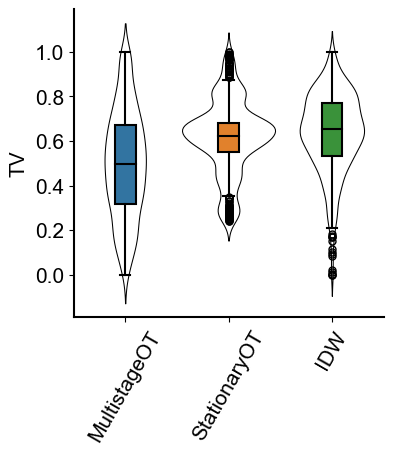

In [92]:
fig, ax = plt.subplots(figsize=(4,4))
sbn.violinplot(ax=ax,data=tv_df, width=0.9,x="model", y="TV", linewidth=0.75, inner=None, color='w',labels=None,zorder=0);

sbn.despine()
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5);
ax.set_yticks([0.2*k for k in range(6)], [str(np.round(0.2*k,1)) for k in range(6)],fontsize=15, **{'fontname':'Arial'})

flierprops = dict(marker='o', markerfacecolor='None', markersize=5,  markeredgecolor='black')
sbn.boxplot(ax=ax,data=tv_df,width=0.2, x="model", y="TV",labels=None,flierprops=flierprops,zorder=10)
for box in ax.patches:
    box.set_edgecolor('k')
    box.set_zorder(100)
    box.set_alpha(1)
    box.set_linewidth(1.5)

[ax.collections[k].set_edgecolor('k') for k in range(len(ax.collections))]
plt.setp(ax.artists, alpha=1,edgecolor = 'k', linewidth=1.5,facecolor='w')
plt.setp(ax.lines,alpha=1,color='k', linewidth=1.5,zorder=100) 


ax.set_xticklabels(['MultistageOT','StationaryOT','IDW'], rotation=60,fontsize=15,**{'fontname':'Arial'})
ax.set_ylabel('TV', fontsize=15,**{'fontname':'Arial'})
ax.set(xlabel=None)

In [94]:
print("MultistageOT RMSE:", np.round(np.sqrt(np.mean(((p_multistageot - q)**2).sum(axis=1) ) ), 2))
print("StationaryOT RMSE: ",np.round(np.sqrt(np.mean(((p_stationaryot - q)**2).sum(axis=1) ) ), 2))
print("IDW RMSE:", np.round(np.sqrt(np.mean(((p_idw - q)**2).sum(axis=1) ) ), 2))


MultistageOT RMSE: 0.68
StationaryOT RMSE:  0.74
IDW RMSE: 0.75


In [97]:
print("MultistageOT mean R2: ", metrics.r2_score(q, p_multistageot).round(2))
print("StationaryOT mean R2: ", metrics.r2_score(q, p_stationaryot).round(2))
print("IDW mean R2: ", metrics.r2_score(q, p_idw).round(2))


MultistageOT mean R2:  0.01
StationaryOT mean R2:  0.06
IDW mean R2:  -0.16


In [98]:
print("MultistageOT variance weighted R2: ", metrics.r2_score(q, p_multistageot,  multioutput = 'variance_weighted').round(2))
print("StationaryOT variance weighted R2: ", metrics.r2_score(q, p_stationaryot, multioutput = 'variance_weighted').round(2))
print("IDW variance weighted R2: ", metrics.r2_score(q, p_idw, multioutput = 'variance_weighted').round(2))


MultistageOT variance weighted R2:  0.19
StationaryOT variance weighted R2:  0.05
IDW variance weighted R2:  0.02


In [99]:
print("MultistageOT mean correlation: ", np.mean([np.corrcoef(q.iloc[:,k], p_multistageot.iloc[:,k])[0][1] for k in range(q.shape[1])]).round(2))
print("StationaryOT mean correlation: ", np.mean([np.corrcoef(q.iloc[:,k], p_stationaryot.iloc[:,k])[0][1] for k in range(q.shape[1])]).round(2))
print("IDW mean correlation: ", np.mean([np.corrcoef(q.iloc[:,k], p_idw.iloc[:,k])[0][1] for k in range(q.shape[1])]).round(2))


MultistageOT mean correlation:  0.32
StationaryOT mean correlation:  0.32
IDW mean correlation:  0.29


In [100]:
print("MultistageOT dominant fate accuracy (%): ", 100*((p_multistageot.idxmax(axis=1) == q.idxmax(axis=1)).sum() / q.shape[0]).round(2))
print("StationaryOT dominant fate accuracy (%): ", 100*((p_stationaryot.idxmax(axis=1) == q.idxmax(axis=1)).sum() / q.shape[0]).round(2))
print("IDW dominant fate accuracy (%): ", 100*((p_idw.idxmax(axis=1) == q.idxmax(axis=1)).sum() / q.shape[0]).round(2))


MultistageOT dominant fate accuracy (%):  54.0
StationaryOT dominant fate accuracy (%):  38.0
IDW dominant fate accuracy (%):  43.0


### Performance over all fate thresholds:

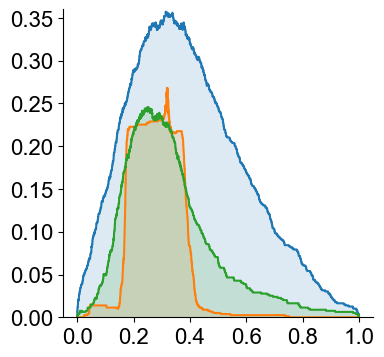

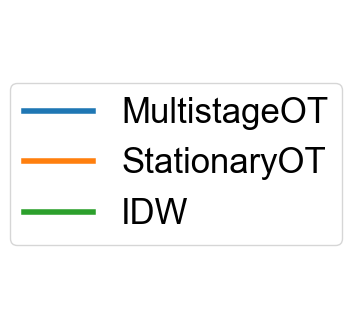

In [102]:
goodness_multistageot = []
goodness_stationaryot = []
goodness_idw = []
goodness_naive = []
goodness_q = []

sensitivities = np.linspace(0,1,10000)

q_binarized = q.copy()
q_binarized.values[q_binarized.values > 0] = 1 

for sensitivity in sensitivities:
    p_multistageot_copy = p_multistageot.copy()
    p_multistageot_copy.values[p_multistageot_copy.values >= sensitivity] = 1
    p_multistageot_copy.values[p_multistageot_copy.values < sensitivity] = 0

    p_idw_copy = p_idw.copy()
    p_idw_copy.values[p_idw_copy.values >= sensitivity] = 1
    p_idw_copy.values[p_idw_copy.values < sensitivity] = 0

    p_stationaryot_copy = p_stationaryot.copy()
    p_stationaryot_copy.values[p_stationaryot_copy.values >= sensitivity] = 1
    p_stationaryot_copy.values[p_stationaryot_copy.values < sensitivity] = 0

    q_ref = q.copy()
    q_ref.values[q_ref.values >= sensitivity] = 1
    q_ref.values[q_ref.values < sensitivity] = 0

    goodness_multistageot.append(((p_multistageot_copy - q_binarized).abs().sum(axis=1) == 0).sum() / q.shape[0])
    goodness_idw.append(((p_idw_copy - q_binarized).abs().sum(axis=1) == 0).sum() / q.shape[0])
    goodness_stationaryot.append(((p_stationaryot_copy - q_binarized).abs().sum(axis=1) == 0).sum() / q.shape[0]) 
    goodness_q.append(((q_ref - q_binarized).abs().sum(axis=1) == 0).sum() / q.shape[0])
    
plt.rcParams["font.family"] = "Arial"
ax = plt.figure(figsize=(4,4))

plt.plot(sensitivities,goodness_multistageot, linewidth=1.5, label='MultistageOT')
plt.fill_between(sensitivities, 0, goodness_multistageot, alpha=0.15)
plt.plot(sensitivities,goodness_stationaryot, linewidth=1.5, label='StationaryOT')
plt.fill_between(sensitivities, 0, goodness_stationaryot, alpha=0.15)
plt.plot(sensitivities,goodness_idw, linewidth=1.5, label='IDW')
plt.fill_between(sensitivities, 0, goodness_idw, alpha=0.15)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

leg_main = plt.legend(fontsize=12)
plt.ylim([0,0.36])
sbn.despine()

ax_main = plt.gca()

#Extract handles and labels:
handles, labels = ax_main.get_legend_handles_labels()

#Remove legend of main figure:
leg_main.remove()
    
#Plot new legend as a separate figure:
fig_legend = plt.figure(figsize=(4,4))  
ax = fig_legend.add_subplot(111)  
ax.axis("off")  

leg = ax.legend(handles, labels, loc='center', prop={'size' : 25}) 

for line in leg.get_lines():
    line.set_linewidth(4.0)

Integrate Area Under the Curve (AUC):

In [103]:
print("AUC MultistageOT:", np.trapz(goodness_multistageot, x=sensitivities).round(2))
print("AUC StationaryOT:", np.trapz(goodness_stationaryot, x=sensitivities).round(2))
print("AUC IDW:", np.trapz(goodness_idw, x=sensitivities).round(2))


AUC MultistageOT: 0.17
AUC StationaryOT: 0.05
AUC IDW: 0.08


Check if MultistageOT is worse on this metric for any threshold:

In [105]:
((np.array(goodness_multistageot) - np.array(goodness_stationaryot)) < 0).sum()

0

We can also check for each cell IF there is ANY threshold for which there is an exact match. If there is, we count it as a correct prediction, otherwise we say it is wrong. Then we compute the accuracy over all cells. We call this total accuracy:

In [108]:
num_predictions = q.shape[0]
predicted_cells = q.index
correct = 0

for cell in predicted_cells:
    #Predicted fate probabilities for cell:
    p = p_multistageot.loc[cell]
    #Find possible fates of cell:
    cell_fates = q_binarized.loc[cell, q_binarized.loc[cell] == 1].index

    #All other cell types not among the possible fates:
    others = q_binarized.loc[cell, q_binarized.loc[cell] != 1].index

    if p[cell_fates].min() > p[others].max():
        correct += 1

new_accuracy_multistageot = correct / num_predictions

correct = 0
for cell in predicted_cells:
    #Predicted fate probabilities for cell:
    p = p_stationaryot.loc[cell]
    #Find possible fates of cell:
    cell_fates = q_binarized.loc[cell, q_binarized.loc[cell] == 1].index

    #All other cell types not among the possible fates:
    others = q_binarized.loc[cell, q_binarized.loc[cell] != 1].index

    if p[cell_fates].min() > p[others].max():
        correct += 1

new_accuracy_stationaryot = correct / num_predictions

correct = 0
for cell in predicted_cells:
    #Predicted fate probabilities for cell:
    p = p_idw.loc[cell]
    #Find possible fates of cell:
    cell_fates = q_binarized.loc[cell, q_binarized.loc[cell] == 1].index

    #All other cell types not among the possible fates:
    others = q_binarized.loc[cell, q_binarized.loc[cell] != 1].index

    if p[cell_fates].min() > p[others].max():
        correct += 1

new_accuracy_idw = correct / num_predictions

In [112]:
print("Total accuracy MultistageOT:", np.round(new_accuracy_multistageot,2))
print("Total accuracy StationaryOT:", np.round(new_accuracy_stationaryot,2))
print("Total accuracy IDW:", np.round(new_accuracy_idw,2))


Total accuracy MultistageOT: 0.56
Total accuracy StationaryOT: 0.46
Total accuracy IDW: 0.46


### Correlations:

In [113]:
cmap_tv = 'bwr'

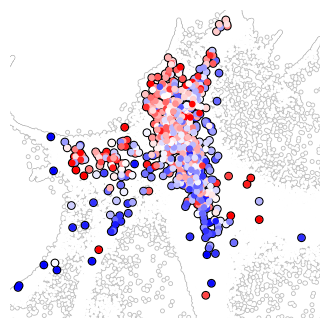

In [115]:
#Plot predictions for all day two cells:

TVD_multistageot = 0.5*np.abs((p_multistageot-q)).sum(axis=1) 
plt.figure(figsize=(4,4))
# Create the scatter plot 
plt.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor=[0.75,0.75,0.75],edgecolor='none', s=12)
plt.scatter(embedding_norm['SPRING-x'] ,embedding_norm['SPRING-y'], facecolor='w',edgecolor='none', s=5)
plt.scatter(embedding_norm.loc[TVD_multistageot.index,'SPRING-x'],embedding_norm.loc[TVD_multistageot.index,'SPRING-y'], facecolor='none', edgecolor='k', s=28)
plt.scatter(embedding_norm.loc[TVD_multistageot.index,'SPRING-x'],embedding_norm.loc[TVD_multistageot.index,'SPRING-y'], c=TVD_multistageot, s=14, cmap=cmap_tv, vmin=0, vmax=1)

sbn.despine(left=True,bottom=True)

plt.ylim([0.28,0.99])
plt.xlim([0.04,0.75])
plt.xticks([])
plt.yticks([])

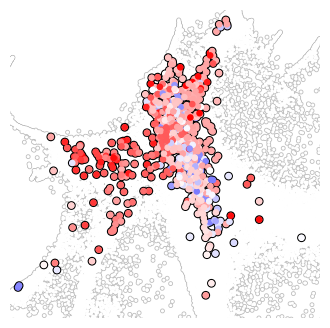

In [118]:
#Plot predictions for all day two cells:

TVD_stationaryot = 0.5*np.abs((p_stationaryot-q)).sum(axis=1) 
plt.figure(figsize=(4,4))
# Create the scatter plot 
plt.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor=[0.75,0.75,0.75],edgecolor='none', s=12)
plt.scatter(embedding_norm['SPRING-x'] ,embedding_norm['SPRING-y'], facecolor='w',edgecolor='none', s=5)
plt.scatter(embedding_norm.loc[TVD_stationaryot.index,'SPRING-x'],embedding_norm.loc[TVD_stationaryot.index,'SPRING-y'], facecolor='none', edgecolor='k', s=28)
plt.scatter(embedding_norm.loc[TVD_stationaryot.index,'SPRING-x'],embedding_norm.loc[TVD_stationaryot.index,'SPRING-y'], c=TVD_stationaryot, cmap=cmap_tv,s=14, vmin=0, vmax=1)

sbn.despine(left=True,bottom=True)

plt.ylim([0.28,0.99])
plt.xlim([0.04,0.75])
plt.xticks([])
plt.yticks([])

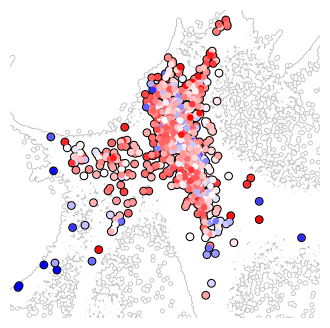

In [119]:
#Plot predictions for all day two cells:

TVD_idw = 0.5*np.abs((p_idw-q)).sum(axis=1) 
plt.figure(figsize=(4,4))
# Create the scatter plot 
plt.scatter(embedding_norm['SPRING-x'],embedding_norm['SPRING-y'], facecolor=[0.75,0.75,0.75],edgecolor='none', s=12)
plt.scatter(embedding_norm['SPRING-x'] ,embedding_norm['SPRING-y'], facecolor='w',edgecolor='none', s=5)
plt.scatter(embedding_norm.loc[TVD_idw.index,'SPRING-x'],embedding_norm.loc[TVD_idw.index,'SPRING-y'], facecolor='none', edgecolor='k', s=28)
plt.scatter(embedding_norm.loc[TVD_idw.index,'SPRING-x'],embedding_norm.loc[TVD_idw.index,'SPRING-y'], cmap=cmap_tv,c=TVD_idw, s=14, vmin=0, vmax=1)

sbn.despine(left=True,bottom=True)

plt.ylim([0.28,0.99])
plt.xlim([0.04,0.75])
plt.xticks([])
plt.yticks([])

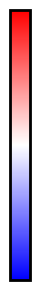

In [120]:
import matplotlib as mpl
fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_genes = mpl.colorbar.ColorbarBase(ax, cmap=cmap_tv, 
                                orientation='vertical')
cb_genes.set_ticks([])
cb_genes.outline.set_linewidth(2)